# Trial 2: Treinamento multiespectral (Todas as bandas) com DAS

## Definições

In [162]:
DATASET = 'b2s'  # b2s ou bfs
TYPE = "multiespectral"
SHOW_INFO = True

BALANCE_DATA = True
USE_TEST_AS_VAL = False
NORMALIZE_BY='Date'
NORMALIZATION_TYPE='std'
TRIAL = 'TESTING'
COMMENTS = ''

AUGMENT = None
# None, simple, default ou advanced
"""
#### AUGMENT: Tipo de aumento de dados:
- None: nenhuma técnica de aumento de dados;
- simple: irá realizar flips na imagem sem alterar a orientação do corte;
- default: irá realizar técnicas de rotação e flip; pode alterar a orientação e a localização do corte;
- advanced: várias técnicas, como rotação, alongamento e zoom; altera a nitidez do corte e produz distorções.
"""
TARGET = 'Eval'

In [163]:
import datetime
NOW = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

In [164]:
AUG_INC = 1
if AUGMENT is None:
    AUG_INC = 1
elif AUGMENT == 'simple':
    AUG_INC = 2
elif AUGMENT == 'default':
    AUG_INC = 4
elif AUGMENT == 'default' and SHAPE[0] == SHAPE[1]:
    AUG_INC = 6
elif AUGMENT == 'advanced':
    AUG_INC = 16
elif AUGMENT == 'advanced' and SHAPE[0] == SHAPE[1]:
    AUG_INC = 18

# Set a optmized shape
if AUGMENT == 'simple' or AUGMENT == 'default':
    DSHAPE = (53, 53)
elif AUGMENT == 'advanced':
    DSHAPE = (80, 80)
else:
    DSHAPE = (43, 53)

### Definições de treinamento

In [165]:
EPOCHS = 2000
LR = 0.01
LOSSF = 'mse'  # mean_squared_logarithmic_error mse
# BATCH_SIZE = AUG_INC + 16
BATCH_SIZE = 45
IM_SHAPE = (DSHAPE[0], DSHAPE[1], 4)
FLATTEN_SHAPE = IM_SHAPE[0]*IM_SHAPE[1]*IM_SHAPE[2]
TOPOLOGY = 'CNN_DAS_leakyrelu4'
MODEL_NAME = f'{TOPOLOGY}_{DATASET}_{TYPE}_{TARGET}_TRIAL_{TRIAL}_AUG_{AUGMENT}_LR{LR}_BS{BATCH_SIZE}_BAL_{BALANCE_DATA}'

In [166]:
if 'CNN' in TOPOLOGY:
    SHAPE = IM_SHAPE
else:
    SHAPE = FLATTEN_SHAPE

## Importação

In [167]:
from datetime import datetime
from os import listdir
from os.path import isfile, join

import os
import glob
import random
import math

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

from sklearn.metrics import r2_score
from sklearn import preprocessing
from tensorflow.keras import backend as K
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesKeras

In [168]:
os.makedirs(f'reports{os.sep}TRIAL{TRIAL}', exist_ok=True)
with open(f'reports/TRIAL{TRIAL}/notes.md', 'w') as f:
    f.write(COMMENTS)

In [169]:
import util
from models import *
from trainutils import *

In [170]:
# Necessário na minha máquina. Estava ocorrendo um erro devido à GPU e esse código resolveu.
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Funções para carregar os dados

### Metadados

In [171]:
dfs = dict()
for f in os.listdir("data"):
    if os.path.splitext(f)[-1] == '.csv':
        dfs[f] = pd.read_csv(os.path.join("data", f))
        
frames = []
for k in dfs:
    if DATASET in k and TYPE in k:
        frames.append(dfs[k])
metadata = pd.concat(frames)
metadata.head(3)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,REP,BLK,PLOT,ENTRY,Trial,Eval,Yield
0,q170505tscrfl_fung_19,crop_tsc_2017_b2s,q170505tscrfl_fung_19_B1.tif,q170505tscrfl_fung_19_B2.tif,q170505tscrfl_fung_19_B3.tif,q170505tscrfl_fung_19_B4.tif,fung_19,1,4,19,17,Fungicide,1.0,6.055209
1,q170505tscrfl_fung_31,crop_tsc_2017_b2s,q170505tscrfl_fung_31_B1.tif,q170505tscrfl_fung_31_B2.tif,q170505tscrfl_fung_31_B3.tif,q170505tscrfl_fung_31_B4.tif,fung_31,2,7,31,19,Fungicide,1.0,4.081627
2,q170419tscrfl_fung_59,crop_tsc_2017_b2s,q170419tscrfl_fung_59_B1.tif,q170419tscrfl_fung_59_B2.tif,q170419tscrfl_fung_59_B3.tif,q170419tscrfl_fung_59_B4.tif,fung_59,3,12,59,10,Fungicide,1.0,4.612393


#### Adicionando data

In [172]:
from datetime import datetime

def extract_date(token):
    date = ''
    for s in token:
        if s.isdigit():
            date += s
    return datetime.strptime(date, '%y%m%d')

In [173]:
metadata['Date'] = metadata.apply(lambda x: extract_date(x['Instance'].split('_')[0]), axis=1)
metadata['Year'] = metadata.apply(lambda x: x.Date.year, axis=1)
metadata.head(3)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,REP,BLK,PLOT,ENTRY,Trial,Eval,Yield,Date,Year
0,q170505tscrfl_fung_19,crop_tsc_2017_b2s,q170505tscrfl_fung_19_B1.tif,q170505tscrfl_fung_19_B2.tif,q170505tscrfl_fung_19_B3.tif,q170505tscrfl_fung_19_B4.tif,fung_19,1,4,19,17,Fungicide,1.0,6.055209,2017-05-05,2017
1,q170505tscrfl_fung_31,crop_tsc_2017_b2s,q170505tscrfl_fung_31_B1.tif,q170505tscrfl_fung_31_B2.tif,q170505tscrfl_fung_31_B3.tif,q170505tscrfl_fung_31_B4.tif,fung_31,2,7,31,19,Fungicide,1.0,4.081627,2017-05-05,2017
2,q170419tscrfl_fung_59,crop_tsc_2017_b2s,q170419tscrfl_fung_59_B1.tif,q170419tscrfl_fung_59_B2.tif,q170419tscrfl_fung_59_B3.tif,q170419tscrfl_fung_59_B4.tif,fung_59,3,12,59,10,Fungicide,1.0,4.612393,2017-04-19,2017


#### Ordenando por nome,crop,data

In [174]:
metadata = metadata.sort_values(['Name', 'Crop', 'Date'])
metadata.head(3)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,REP,BLK,PLOT,ENTRY,Trial,Eval,Yield,Date,Year
82,c160407tscrfl_fung_1,crop_tsc_2016_b2s,c160407tscrfl_fung_1_B1.tif,c160407tscrfl_fung_1_B2.tif,c160407tscrfl_fung_1_B3.tif,c160407tscrfl_fung_1_B4.tif,fung_1,1,1,1,22,Fungicide,1.0,5.296382,2016-04-07,2016
335,c160418tscrfl_fung_1,crop_tsc_2016_b2s,c160418tscrfl_fung_1_B1.tif,c160418tscrfl_fung_1_B2.tif,c160418tscrfl_fung_1_B3.tif,c160418tscrfl_fung_1_B4.tif,fung_1,1,1,1,22,Fungicide,1.0,5.296382,2016-04-18,2016
565,c160428tscrfl_fung_1,crop_tsc_2016_b2s,c160428tscrfl_fung_1_B1.tif,c160428tscrfl_fung_1_B2.tif,c160428tscrfl_fung_1_B3.tif,c160428tscrfl_fung_1_B4.tif,fung_1,1,1,1,22,Fungicide,1.0,5.296382,2016-04-28,2016


#### Definindo a instância

Neste experimento vamos considerar cada plot individual como uma instância. Um plot é o conjunto de 4 diferentes bandas espectrais de uma data específica.

In [175]:
metadata['Name'] = metadata.apply(lambda x: f'{(x.Name.split("_")[0])}_{int(x.Name.split("_")[1]):03}', axis=1)

In [176]:
metadata['Instance'] = metadata.apply(lambda x: f'{x.Name}_{x.Crop}_{x.Date.year}{x.Date.month}{x.Date.day}', axis=1)

In [177]:
metadata.head()

,Instance,Crop,B1File,B2File,B3File,B4File,Name,REP,BLK,PLOT,ENTRY,Trial,Eval,Yield,Date,Year
82,fung_001_crop_tsc_2016_b2s_201647,crop_tsc_2016_b2s,c160407tscrfl_fung_1_B1.tif,c160407tscrfl_fung_1_B2.tif,c160407tscrfl_fung_1_B3.tif,c160407tscrfl_fung_1_B4.tif,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-07,2016
335,fung_001_crop_tsc_2016_b2s_2016418,crop_tsc_2016_b2s,c160418tscrfl_fung_1_B1.tif,c160418tscrfl_fung_1_B2.tif,c160418tscrfl_fung_1_B3.tif,c160418tscrfl_fung_1_B4.tif,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-18,2016
565,fung_001_crop_tsc_2016_b2s_2016428,crop_tsc_2016_b2s,c160428tscrfl_fung_1_B1.tif,c160428tscrfl_fung_1_B2.tif,c160428tscrfl_fung_1_B3.tif,c160428tscrfl_fung_1_B4.tif,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-28,2016
10,fung_001_crop_tsc_2016_b2s_2016511,crop_tsc_2016_b2s,c160511tscrfl_fung_1_B1.tif,c160511tscrfl_fung_1_B2.tif,c160511tscrfl_fung_1_B3.tif,c160511tscrfl_fung_1_B4.tif,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-05-11,2016
385,fung_001_crop_tsc_2017_b2s_2017419,crop_tsc_2017_b2s,q170419tscrfl_fung_1_B1.tif,q170419tscrfl_fung_1_B2.tif,q170419tscrfl_fung_1_B3.tif,q170419tscrfl_fung_1_B4.tif,fung_001,1,1,1,23,Fungicide,1.0,5.643749,2017-04-19,2017


In [178]:
for key in ['B1File', 'B2File', 'B3File', 'B4File']:
    metadata[key] = metadata.apply(lambda x: os.path.join('data', 'RAW', x['Crop'], x[key]), axis=1)
metadata.head(3)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,REP,BLK,PLOT,ENTRY,Trial,Eval,Yield,Date,Year
82,fung_001_crop_tsc_2016_b2s_201647,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-07,2016
335,fung_001_crop_tsc_2016_b2s_2016418,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-18,2016
565,fung_001_crop_tsc_2016_b2s_2016428,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-28,2016


#### Definindo *Days after sowing*

In [179]:
sowing_2016 = datetime.strptime('2016-01-19', '%Y-%m-%d')
sowing_2017 = datetime.strptime('2017-01-24', '%Y-%m-%d')

def get_das(date):
    if date.year == 2016:
        return (date - sowing_2016).days
    elif date.year == 2017:
        return (date - sowing_2017).days

In [180]:
metadata['DAS'] = metadata.apply(lambda x: get_das(x.Date), axis=1)
metadata.head(3)

,Instance,Crop,B1File,B2File,B3File,B4File,Name,REP,BLK,PLOT,ENTRY,Trial,Eval,Yield,Date,Year,DAS
82,fung_001_crop_tsc_2016_b2s_201647,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160407tscrfl_fung_...,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-07,2016,79
335,fung_001_crop_tsc_2016_b2s_2016418,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160418tscrfl_fung_...,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-18,2016,90
565,fung_001_crop_tsc_2016_b2s_2016428,crop_tsc_2016_b2s,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,data/RAW/crop_tsc_2016_b2s/c160428tscrfl_fung_...,fung_001,1,1,1,22,Fungicide,1.0,5.296382,2016-04-28,2016,100


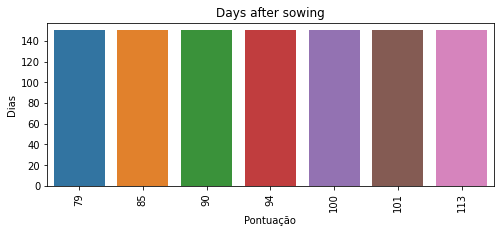

In [181]:
if SHOW_INFO:
    plt.figure(figsize=(8,3))
    evals = metadata['DAS'].value_counts()
    sns.barplot(evals.index, evals.values)
    plt.xticks(rotation='vertical')
    plt.xlabel('Pontuação')
    plt.ylabel('Dias')
    plt.title("Days after sowing")
    plt.show()

#### Normalizando DAS

In [182]:
metadata['DAS'] = (metadata['DAS']-metadata['DAS'].min())/(metadata['DAS'].max()-metadata['DAS'].min())
metadata['DAS']

82     0.000000
335    0.323529
565    0.617647
10     1.000000
385    0.176471
         ...   
472    0.617647
54     1.000000
130    0.176471
141    0.441176
89     0.647059
Name: DAS, Length: 1050, dtype: float64

### Split dos dados

Nesse experimento os dados com fungicidas serão desconsiderados.

In [183]:
metadata = metadata[metadata.Trial != 'Fungicide']

In [184]:
train_metadata = metadata[metadata.REP < 3]
test_metadata = metadata[metadata.REP == 3]
if USE_TEST_AS_VAL:
    val_metadata = test_metadata
else:
    val_metadata = test_metadata.sample(frac=.5)
    cond = val_metadata['Instance'].isin(test_metadata['Instance'])
    test_metadata.drop(val_metadata[cond].index, inplace=True)
print("Tamanho dos dados de treinamento: ", len(train_metadata))
print("Tamanho dos dados de validação: ", len(val_metadata))
print("Tamanho dos dados de teste: ", len(test_metadata))

Tamanho dos dados de treinamento:  350
Tamanho dos dados de validação:  88
Tamanho dos dados de teste:  82


/home/lucas/anaconda3/envs/ic2/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


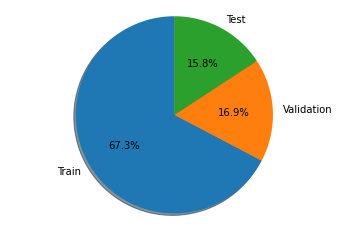

In [185]:
if SHOW_INFO:
    total = len(train_metadata) + len(val_metadata) + len(test_metadata)
    sizes = [len(train_metadata)/total, len(val_metadata)/total, len(test_metadata)/total]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=["Train", "Validation", "Test"], autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')
    plt.show()

In [186]:
print("Quantidade de instâncias (sem aumento de dados) totais:",
      len(metadata))
print("Quantidade de instâncias (sem aumento de dados) para treinamento:",
      len(train_metadata))
print("Quantidade de instâncias (sem aumento de dados) para validação:",
      len(val_metadata))
print("Quantidade de instâncias (sem aumento de dados) para teste:",
      len(test_metadata))

train_set = set(train_metadata.Instance)
val_set = set(val_metadata.Instance) if not USE_TEST_AS_VAL else set()
test_set = set(test_metadata.Instance)
for i in val_set:
    assert not (i in train_set or i in test_set)
for i in test_set:
    assert not (i in train_set or i in val_set)

Quantidade de instâncias (sem aumento de dados) totais: 525
Quantidade de instâncias (sem aumento de dados) para treinamento: 350
Quantidade de instâncias (sem aumento de dados) para validação: 88
Quantidade de instâncias (sem aumento de dados) para teste: 82


#### Balanceamento dos dados

In [187]:
if BALANCE_DATA:
    g = train_metadata.groupby(TARGET, as_index=False)
    metadata_bal = pd.DataFrame(g.apply(lambda x: x.sample(g.size().max(),
                                                           replace=True).reset_index(drop=True)))
    metadata_bal.reset_index(drop=True, inplace=True)
    train_metadata = metadata_bal

#### Carregando alguns dados

In [189]:
print(NORMALIZE_BY)

Date


In [190]:
train_gen = RegressorDASGenerator(metadata_flow=train_metadata,
                                  new_shape=SHAPE, 
                                  metadata=metadata,
                                  batch_size=BATCH_SIZE,
                                  loader_fn=util.process, 
                                  train_metadata=train_metadata, 
                                  val_metadata=val_metadata,
                                  test_metadata=test_metadata,
                                  augmentation=AUG_INC,
                                  normalize_by=NORMALIZE_BY,
                                  normalization_type=NORMALIZATION_TYPE,
                                  target=TARGET,
                                  loader_kw={"im_shape": IM_SHAPE,
                                             "augment_type": AUGMENT,
                                             "verbose_level": 0})

for i in train_gen:
    print(np.asarray(i[0][0]).shape)
    break

(45, 43, 53, 4)


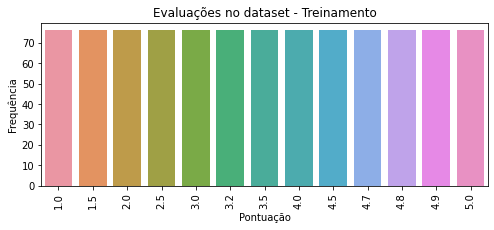

In [191]:
if SHOW_INFO:
    plt.figure(figsize=(8,3))
    evals = train_metadata['Eval'].value_counts()
    sns.barplot(evals.index, evals.values)
    plt.xticks(rotation='vertical')
    plt.xlabel('Pontuação')
    plt.ylabel('Frequência')
    plt.title("Evaluações no dataset - Treinamento")
    plt.show()

In [192]:
loader_kws = {
    'im_shape': IM_SHAPE, 
    'augment_type': None,
    'verbose_level': 0
}

dataset = DASDataset(metadata, 
                     train_metadata=train_metadata, 
                     val_metadata=val_metadata, 
                     test_metadata=test_metadata,
                     loader_fn=util.process, 
                      normalize_by=NORMALIZE_BY,
                      normalization_type=NORMALIZATION_TYPE,
                     loader_kw=loader_kws, 
                     target=TARGET)
dataset.load_train_val_test_data()

train_features, train_das, train_y = dataset.train_data
val_features, val_das, val_y = dataset.val_data
test_features, test_das, test_y = dataset.test_data

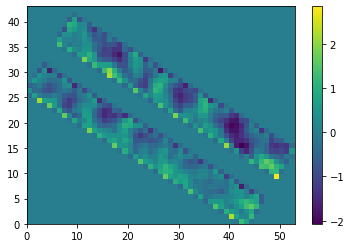

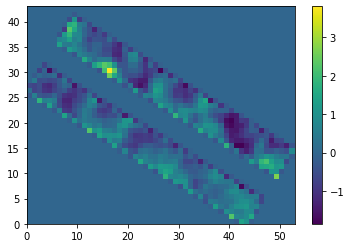

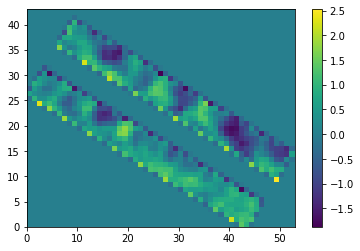

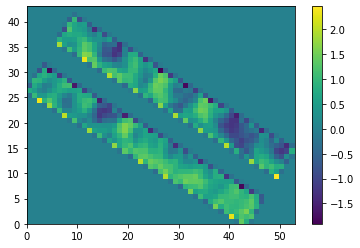

In [193]:
if SHOW_INFO:
    for c in range(4):
        plt.pcolormesh(train_features[0][:,:,c])
        plt.axis('equal')
        plt.colorbar()
        plt.show()
        plt.close()

In [194]:
if SHAPE == FLATTEN_SHAPE:
    val_features = np.reshape(np.asarray(val_features), (len(val_features), FLATTEN_SHAPE))
    train_features = np.reshape(np.asarray(train_features), (len(train_features), FLATTEN_SHAPE))
    test_features = np.reshape(np.asarray(test_features), (len(test_features), FLATTEN_SHAPE))

## Métricas

In [195]:
def R_squared(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

def r2_keras(y_true, y_pred):
#     return tfa.metrics.RSquare(y_true, y_pred)

    RSS =  K.sum(K.square( y_true- y_pred ))
    TSS = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1. - RSS/(TSS) )

def pearson_r(y_true, y_pred):
    # ToDo
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

## Modelos

**Veja models.py**

In [196]:
model = globals()[TOPOLOGY](SHAPE)

### Otimizador

In [197]:
def exp_decay(epoch):
    k = 0.1
    lrate = LR * math.exp(-k*2)
    return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(exp_decay)

In [198]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

In [36]:
decay_rate = (LR / EPOCHS)
optimizer = tf.keras.optimizers.Adam(lr=LR, decay=decay_rate)

### Compile

In [37]:
model.compile(loss=LOSSF,
              optimizer=optimizer,
              metrics=['mse', r2_keras, R_squared, pearson_r])

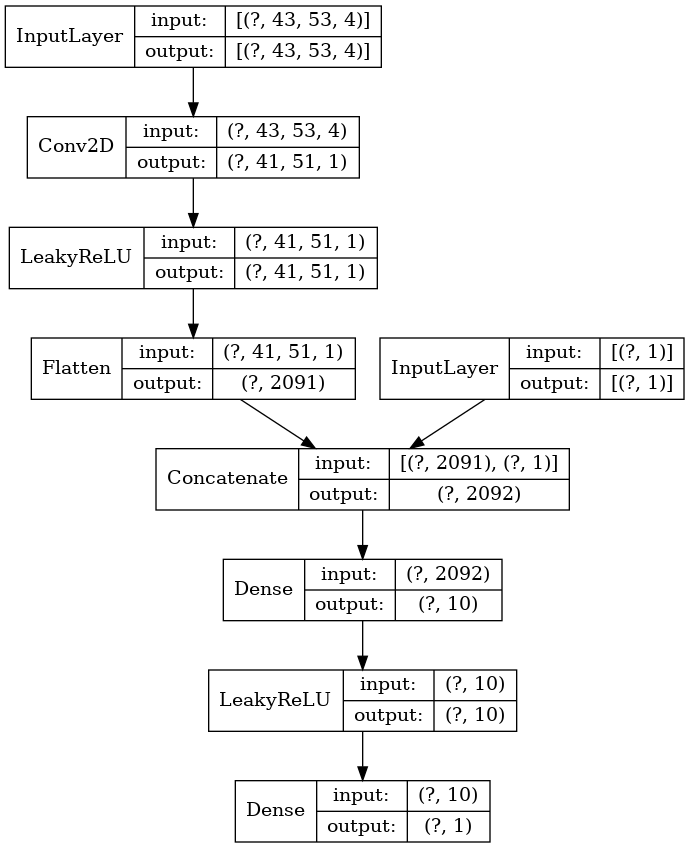

In [38]:
os.makedirs('topologias', exist_ok=True)
plot_model(model, to_file=f'topologias{os.sep}{TOPOLOGY}.png',
           show_shapes=True, show_layer_names=False)

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43, 53, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 41, 51, 1)    37          input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 41, 51, 1)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2091)         0           leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [40]:
print(test_features.shape, test_das.shape, test_y.shape)

(80, 43, 53, 4) (80, 1) (80,)


In [41]:
loss, mse, r2, R2, p = model.evaluate([test_features, test_das], test_y, verbose=1)
print(f"Loss={loss}\nMSE={mse}\nR2={r2}\nR2={R2}\nPearson={p}")

3/3 [==============================] - 0s 9ms/step - loss: 65.5048 - mse: 9.5049 - r2_keras: -3.8999 - R_squared: -3.8999 - pearson_r: -0.2310
Loss=65.50484466552734
MSE=9.504921913146973
R2=-3.8999359607696533
R2=-3.8999359607696533
Pearson=-0.2310095578432083


In [42]:
interv = EPOCHS//50
plot_metrics = PlotMetricsRegressor([val_features, val_das], val_y, 1, suavize_data=None,
                                    savefig=f'{MODEL_NAME}_{NOW}', savefig_epoch=EPOCHS-interv)

## Treinamento

In [92]:
checkpoint_filepath = f'models/{MODEL_NAME}_{NOW}.h5'

os.makedirs('models', exist_ok=True)
callbacks = [
#     lrate,
    ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
#         mode='max',
        monitor='val_loss',
#         monitor='val_r2_keras',
        verbose=1)
]
if SHOW_INFO:
    callbacks.append(plot_metrics)
    callbacks.append(ShowLR())
    
start = datetime.now()


if AUGMENT is not None:
    print("Using generator")
    train_gen = RegressorDASGenerator(metadata_flow=train_metadata,
                                      metadata=metadata,
                                      train_metadata=train_metadata, 
                                      val_metadata=val_metadata, 
                                      test_metadata=test_metadata,
                                      batch_size=BATCH_SIZE,
                                      loader_fn=util.process, 
                                      augmentation=AUG_INC,
                                      use_cache=False,
                                      standardize_by_rep=STANDARDIZE_DATA,
                                      normalize_by_rep=NORMALIZE_DATA,
                                      target=TARGET,
                                      new_shape=SHAPE,
                                      loader_kw={"im_shape": IM_SHAPE,
                                                 "augment_type": AUGMENT,
                                                 "verbose_level": 0})
    history = model.fit(x=train_gen, 
                        epochs=EPOCHS,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=([val_features, val_das], val_y),
                        max_queue_size=10,
                        workers=7,
                        use_multiprocessing=False)
else:
    history = model.fit(x=[train_features, train_das],
                        y=train_y,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=([val_features, val_das], val_y))


duration = datetime.now() - start
print("Training completed in time: ", duration)

NameError: name 'model' is not defined

### Teste

In [ ]:
print("*"*10, "TEST (TRAIN SET)", "*"*10)
train_loss, train_mse, train_r2, train_R2, train_p = model.evaluate([train_features, train_das], train_y, verbose=1)
print(f"Loss={train_loss}\nMSE={train_mse}\nr2={train_r2}\nR2={train_r2}\nPearson={train_p}")

print("*"*10, "TEST (VAL SET)", "*"*10)
val_loss, val_mse, val_r2, val_R2, val_p = model.evaluate([val_features, val_das], val_y, verbose=1)
print(f"Loss={val_loss}\nMSE={val_mse}\nr2={val_r2}\nR2={val_r2}\nPearson={val_p}")

print("*"*10, "TEST (TEST SET)", "*"*10)
test_loss, test_mse, test_r2, test_R2, test_p = model.evaluate([test_features, test_das], test_y, verbose=1)
print(f"Loss={test_loss}\nMSE={test_mse}\rR2={test_r2}\nR2={test_r2}\nPearson={test_p}")

## Teste do melhor modelo

In [ ]:
model = load_model(checkpoint_filepath, custom_objects={"r2_keras": r2_keras, "R_squared": R_squared, "pearson_r": pearson_r})

### Teste

In [ ]:
print("*"*10, "TEST (TRAIN SET)", "*"*10)
train_loss, train_mse, train_r2, train_R2, train_p = model.evaluate([train_features, train_das], train_y, verbose=1)
print(f"Loss={train_loss}\nMSE={train_mse}\nr2={train_r2}\nR2={train_r2}\nPearson={train_p}")

print("*"*10, "TEST (VAL SET)", "*"*10)
val_loss, val_mse, val_r2, val_R2, val_p = model.evaluate([val_features, val_das], val_y, verbose=1)
print(f"Loss={val_loss}\nMSE={val_mse}\nr2={val_r2}\nR2={val_r2}\nPearson={val_p}")

print("*"*10, "TEST (TEST SET)", "*"*10)
test_loss, test_mse, test_r2, test_R2, test_p = model.evaluate([test_features, test_das], test_y, verbose=1)
print(f"Loss={test_loss}\nMSE={test_mse}\rR2={test_r2}\nR2={test_r2}\nPearson={test_p}")

### Predições

In [ ]:
test_predictions = model.predict([test_features, test_das])

In [ ]:
val_predictions = model.predict([val_features, val_das])

In [ ]:
train_predictions = model.predict([train_features, train_das])

In [ ]:
train_r2 = r2_score(train_y, train_predictions)
val_r2 = r2_score(val_y, val_predictions)
test_r2 = r2_score(test_y, test_predictions)

In [ ]:
print('R2 Train set:', r2_score(train_y, train_predictions))
print('R2 Validation set:', r2_score(val_y, val_predictions))
print('R2 Test set:', r2_score(test_y, test_predictions))

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
os.makedirs(f'reports{os.sep}TRIAL{TRIAL}{os.sep}PREDICT', exist_ok=True)

ax1.scatter(train_y, train_predictions, marker='.', color='r')
ax1.set_xlabel('True Values')
ax1.set_ylabel('Predictions')
ax1.set_title('Train Predictions')
ax1.axis('equal')
ax1.axis('square')
_ = ax1.plot([-100, 100], [-100, 100])

ax2.scatter(val_y, val_predictions, marker='.')
ax2.set_xlabel('True Values')
ax2.set_ylabel('Predictions')
ax2.set_title('Val Predictions')
ax2.axis('equal')
ax2.axis('square')
_ = ax2.plot([-100, 100], [-100, 100])

ax3.scatter(test_y, test_predictions, marker='.', color='g')
ax3.set_xlabel('True Values')
ax3.set_ylabel('Predictions')
ax2.set_title('Test Predictions')
ax3.axis('equal')
ax3.axis('square')
_ = ax3.plot([-100, 100], [-100, 100])
plt.savefig(f'reports{os.sep}TRIAL{TRIAL}{os.sep}PREDICT{os.sep}{MODEL_NAME}_{NOW}.png')

plt.show()
plt.close()

In [ ]:
_, ax = plt.subplots()
ax.scatter(x = range(0, test_y.size), y=test_y, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, test_predictions.size), y=test_predictions, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()
plt.close()

In [ ]:
diff = test_y.reshape(test_predictions.shape) - test_predictions
plt.hist(diff, bins=40)
plt.title('Histogram of prediction errors')
plt.xlabel('MPG prediction error')
plt.ylabel('Frequency')
plt.close()

**Plot metrics and losses**

In [ ]:
def smooth_curve(points, factor=0.75):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [ ]:
os.makedirs(f'reports{os.sep}TRIAL{TRIAL}{os.sep}LOSS', exist_ok=True)
plt.plot(smooth_curve(history.history['loss']))
plt.plot(smooth_curve(history.history['val_loss']))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(f'reports{os.sep}TRIAL{TRIAL}{os.sep}LOSS{os.sep}{MODEL_NAME}_{NOW}.png')
plt.show()
plt.close()

In [ ]:
os.makedirs(f'reports{os.sep}TRIAL{TRIAL}{os.sep}R2', exist_ok=True)
plt.plot(smooth_curve(history.history['r2_keras']))
plt.plot(smooth_curve(history.history['val_r2_keras']))
plt.title('R2')
plt.ylabel('R2')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(f'reports{os.sep}TRIAL{TRIAL}{os.sep}R2{os.sep}{MODEL_NAME}_{NOW}.png')
plt.show()
plt.close()

In [ ]:
os.makedirs(f'reports{os.sep}TRIAL{TRIAL}{os.sep}Pearson', exist_ok=True)
plt.plot(smooth_curve(history.history['pearson_r']))
plt.plot(smooth_curve(history.history['val_pearson_r']))
plt.title('Pearson')
plt.ylabel('Pearson')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(f'reports{os.sep}TRIAL{TRIAL}{os.sep}Pearson{os.sep}{MODEL_NAME}_{NOW}.png')
plt.show()
plt.close()

__Write csv__

In [ ]:
hist_df = pd.DataFrame(history.history) 

os.makedirs(f'reports{os.sep}TRIAL{TRIAL}{os.sep}history', exist_ok=True)
hist_csv_file = f'reports{os.sep}TRIAL{TRIAL}{os.sep}history/{TOPOLOGY}__{MODEL_NAME}_{NOW}.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
os.makedirs(f'reports{os.sep}TRIAL{TRIAL}{os.sep}predictions', exist_ok=True)

pred_csv_file = f'reports{os.sep}TRIAL{TRIAL}{os.sep}predictions/{MODEL_NAME}_{NOW}.csv'

with open(pred_csv_file, mode='w') as f:
    f.write("TRUE,PREDICTED\n")
    for y_true, y_pred in zip(test_y, test_predictions):
        f.write(f"{y_true},{y_pred[0]}\n")

In [ ]:
if not os.path.isfile(f'reports{os.sep}TRIAL{TRIAL}{os.sep}report.csv'):
    with open(f'reports{os.sep}TRIAL{TRIAL}{os.sep}report.csv', 'a') as report:
        report.write('DATA,NOME,TOPOLOGIA,DATASET,VAL_IS_TEST,'
                     'TARGET,AUGMENTATION,EPOCAS,LR,LOSSFUNC,'
                     'TRAIN_LOSS,TRAIN_MSE,TRAIN_R2,TRAIN_PEARSON,'
                     'VAL_LOSS,VAL_MSE,VAL_R2,VAL_PEARSON,'
                     'TEST_LOSS,TEST_MSE,TEST_R2,TEST_PEARSON,\n')
with open(f'reports{os.sep}TRIAL{TRIAL}{os.sep}report.csv', 'a') as report:
    report.write(f'{datetime.now()},{MODEL_NAME},{TOPOLOGY},{DATASET},'
                 f'{USE_TEST_AS_VAL},{TARGET},{AUGMENT},{EPOCHS},{LR},{LOSSF},'
                 f'{train_loss},{train_mse},{train_r2},{train_p},'
                 f'{val_loss},{val_mse},{val_r2},{val_p},'
                 f'{test_loss},{test_mse},{test_r2},{test_p}\n')